In [3]:
# This notebook is totally exploratory. I'm simply keeping a
# record of every graph and significant observation I made here.
# More polished EDAs will be included as well.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [25]:
userdata_path = "C:\\Users\\d\\capstone1\\data\\interim\\train_users_2.csv"
sessions_path = "C:\\Users\\d\\capstone1\\data\\interim\\sessions.csv"

userdf = pd.read_csv(userdata_path, engine='python')
sessionsdf = pd.read_csv(sessions_path, engine='python')

rawuserdata_path = "C:\\Users\\d\\capstone1\\data\\raw\\train_users_2.csv"
rawsessions_path = "C:\\Users\\d\\capstone1\\data\\raw\\sessions.csv"

rawuserdf = pd.read_csv(rawuserdata_path, engine='python')
rawsessionsdf = pd.read_csv(rawsessions_path, engine='python')

In [5]:
print(userdf.columns)
print(userdf['timestamp_first_active'].unique())
print(userdf['date_first_booking'].unique())
print(userdf['date_account_created'].unique())

print(sessionsdf.columns)

Index(['Unnamed: 0', 'id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')
[20140101000936 20140101002742 20140101005837 ... 20140630235340
 20140630235547 20140630235636]
['2014-01-04' '2014-01-07' nan '2014-01-02' '2014-04-19' '2014-02-26'
 '2014-01-01' '2014-05-27' '2014-08-27' '2014-07-28' '2014-03-24'
 '2014-03-25' '2014-01-06' '2014-01-09' '2014-05-08' '2014-01-21'
 '2014-02-28' '2014-01-10' '2014-01-13' '2014-01-15' '2014-01-05'
 '2014-05-19' '2014-03-11' '2014-01-03' '2014-02-11' '2014-02-04'
 '2014-09-02' '2014-02-23' '2014-01-08' '2014-01-14' '2014-07-12'
 '2014-02-05' '2014-02-06' '2014-01-16' '2014-01-19' '2014-03-31'
 '2014-02-12' '2014-09-14' '2014-04-15' '2014-11-09' '2014-11-25'
 '2014-08-01' '

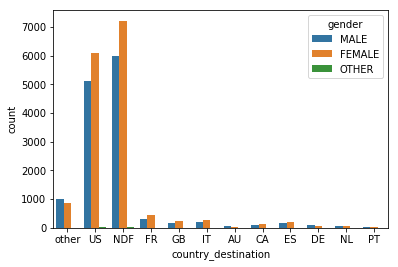

In [6]:
sns.countplot(data=userdf, x='country_destination', hue='gender')

# Females are more likely to make a booking overall. Males are only
# more likely to go to Australia or somewhere more exotic than Europe.

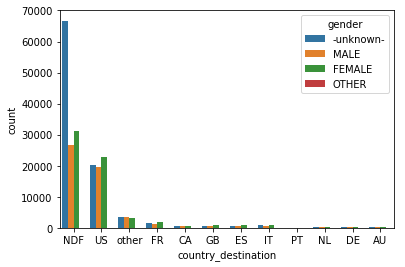

In [7]:
sns.countplot(data=rawuserdf, x='country_destination', hue='gender')

# This plot suggests to me that the main reason for 'unknown' gender is
# that the person was on the fence about their signup in the first place.
# This tells me that 'unknown' is actually a significant source of
# information about the user. If they don't specify a gender, they aren't
# likely to make a booking.

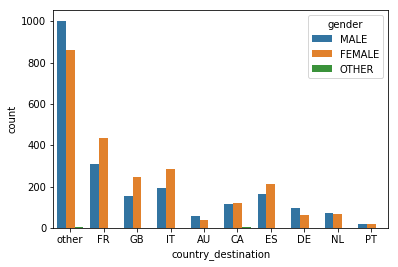

In [8]:
userdf1 = userdf[userdf['country_destination'] != 'US']
userdf1 = userdf1[userdf1['country_destination'] != 'NDF']
sns.countplot(data=userdf1, x='country_destination', hue='gender')

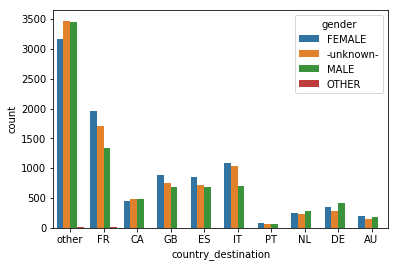

In [9]:
rawuserdf1 = rawuserdf[rawuserdf['country_destination'] != 'US']
rawuserdf1 = rawuserdf1[rawuserdf1['country_destination'] != 'NDF']
sns.countplot(data=rawuserdf1, x='country_destination', hue='gender')

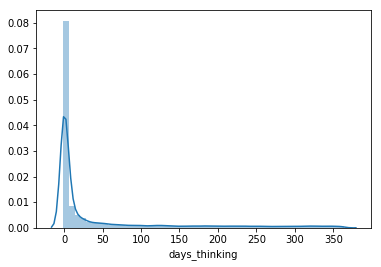

In [67]:
userdf['timestamp_first_active'] = pd.to_datetime(userdf['timestamp_first_active'], format='%Y%m%d%H%M%S')
userdf['date_first_booking'] = pd.to_datetime(userdf['date_first_booking'])
userdf['days_thinking'] = userdf['date_first_booking'] - userdf['timestamp_first_active']

hist1 = userdf
hist1['days_thinking'] = hist1['days_thinking'].astype('timedelta64[D]')

hist1 = hist1.dropna()

sns.distplot(hist1['days_thinking'])

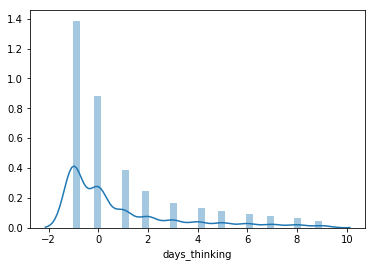

In [11]:
hist2 = hist1[hist1['days_thinking'] < 10]

sns.distplot(hist2['days_thinking'])

In [12]:
print(userdf.iloc[12])

# There are actually times where days thinking is
# a negative number. It appears this comes from
# when we converted date_first_booking to a datetime
# object. There are no hours here, so timestamp is
# actually bigger. Let's set the values to 0 to
# accurately reflect a same-day booking and go again.

Unnamed: 0                              137056
id                                  9v9pjiw5s1
date_account_created                2014-01-01
timestamp_first_active     2014-01-01 03:53:58
date_first_booking         2014-01-01 00:00:00
gender                                    MALE
age                                         25
signup_method                            basic
signup_flow                                  0
language                                    en
affiliate_channel                    sem-brand
affiliate_provider                      google
first_affiliate_tracked                 linked
signup_app                                 Web
first_device_type                  Mac Desktop
first_browser                           Safari
country_destination                         US
days_thinking                               -1
Name: 12, dtype: object


C:\Users\d\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


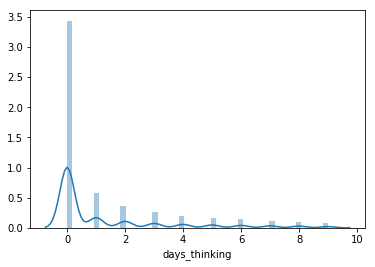

In [13]:
hist2.loc[hist2['days_thinking'] < 0, 'days_thinking'] = 0

sns.distplot(hist2['days_thinking'])

# Looks like the vast majority of people make their first
# booking on the day they are first active on the site.
# timestamp_first_active, therefore is simply the beginning
# of the session in which a user decides to make a booking
# and create an account. It is reasonable to conclude that
# users EITHER make a booking the first time they visit
# Airbnb OR our data collector does not capture sessions
# data from users' first sessions in which they visit the
# site but do not create an account.

In [26]:
action_count = sessionsdf.groupby('user_id', as_index=False).count()

# Looks like for this table, some actions and some action types are blank.
# The most reliable column is device_type, which always has a value. So
# we can use its count.

action_count = action_count[['user_id', 'device_type']]
action_count.columns = ['id', 'number_of_actions']

userdf = pd.merge(userdf, action_count, on='id')

       Unnamed: 0          id date_account_created  timestamp_first_active  \
0          137021  d1mm9tcy42           2014-01-01          20140101000936   
1          137027  xwxei6hdk4           2014-01-01          20140101002742   
2          137031  qtw88d9pbl           2014-01-01          20140101005837   
3          137032  awiurksqr3           2014-01-01          20140101010113   
4          137035  cuxu2kbaep           2014-01-01          20140101010952   
5          137036  jrqykh9y8x           2014-01-01          20140101011919   
6          137037  s9xrwtyzsq           2014-01-01          20140101012345   
7          137038  1ltangt0hg           2014-01-01          20140101012405   
8          137043  ayguekg4tf           2014-01-01          20140101020426   
9          137048  oa8oz6sj6s           2014-01-01          20140101023848   
10         137050  w19d8pogt0           2014-01-01          20140101030401   
11         137051  7105aijtcm           2014-01-01          2014

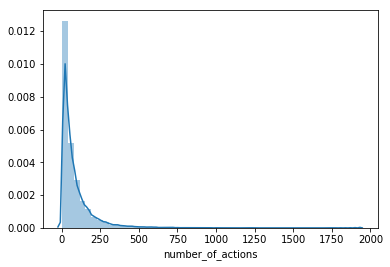

In [27]:
hist3 = sns.distplot(userdf['number_of_actions'])

# Looks like most people spend less than 250 actions on the site.
# I wonder if the number of actions correlates to whether the
# user booked a destination...

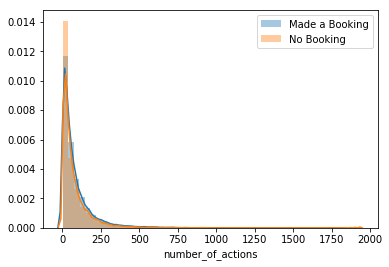

In [108]:
booked = userdf[userdf['country_destination'] != 'NDF']
no_booked = userdf[userdf['country_destination'] == 'NDF']

sns.distplot(booked['number_of_actions'], label='Made a Booking')
sns.distplot(no_booked['number_of_actions'], label='No Booking')
plt.legend()

# Hard to tell. Let's get a better look.

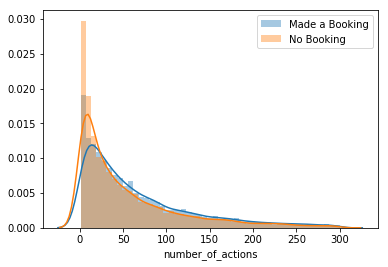

In [35]:
booked2 = booked[booked['number_of_actions'] <= 300]
no_booked2 = no_booked[no_booked['number_of_actions'] <= 300]

sns.distplot(booked2['number_of_actions'], label='Made a Booking')
sns.distplot(no_booked2['number_of_actions'], label='No Booking')
plt.legend()

# Looks like the number of actions doesn't strongly correlate to
# whether or not a booking was made. If you stay on the site longer,
# you're a little more likely to make a booking. As expected.

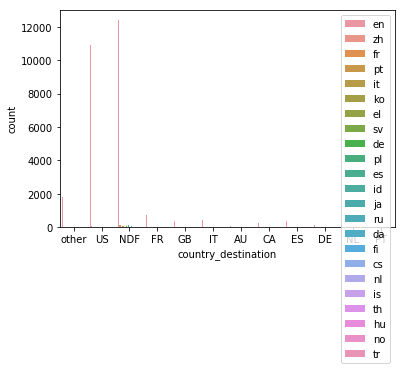

In [42]:
sns.countplot(data=userdf, x='country_destination', hue='language')
plt.legend(loc='upper right')

# Ugly graph...

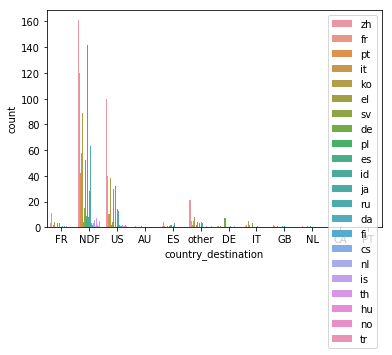

In [43]:
noeng = userdf[userdf['language'] != 'en']

sns.countplot(data=noeng, x='country_destination', hue='language')
plt.legend(loc='upper right')

# Ugly still...but it looks like we've found a trend.
# Chinese speakers are much more likely to visit the US
# than any other language group (besides English speakers).
# It also appears that language speakers are more likely
# to book a destination in their own country...

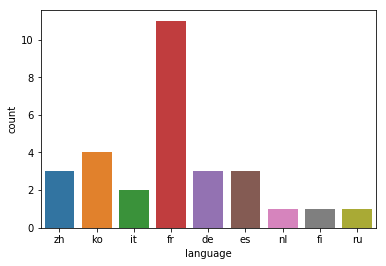

In [50]:
noengFR = noeng[noeng['country_destination'] == 'FR']

sns.countplot(data=noengFR, x='language')

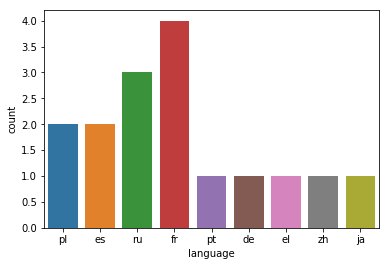

In [51]:
noengES = noeng[noeng['country_destination'] == 'ES']

sns.countplot(data=noengES, x='language')

# French speakers are the most likely to visit Spain.
# This could also indicate that there are more French-
# speaking users than Spanish-speaking. Russian and
# Polish are also both high...

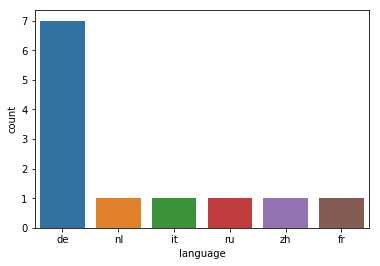

In [52]:
noengDE = noeng[noeng['country_destination'] == 'DE']

sns.countplot(data=noengDE, x='language')

# Germans want to visit Germany.

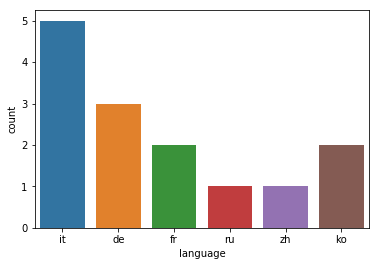

In [53]:
noengIT = noeng[noeng['country_destination'] == 'IT']

sns.countplot(data=noengIT, x='language')

# Italians visit Italy the most. Pretty small pool...

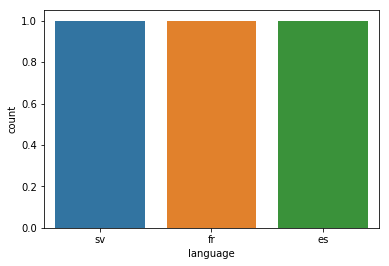

In [55]:
noengNL = noeng[noeng['country_destination'] == 'NL']

sns.countplot(data=noengNL, x='language')

# Here we are seeing just three bookings to Netherlands.
# Inappropriate to draw conclusions from it.

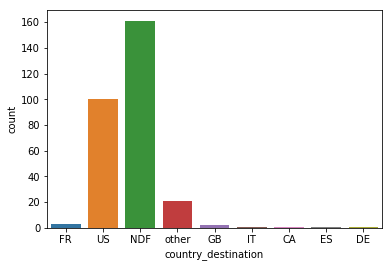

In [63]:
# Where do Chinese speakers go?

userdfZH = userdf[userdf['language'] == 'zh']

sns.countplot(data=userdfZH, x='country_destination')

# Nowhere, then US, then other parts of the world.
# Not really Europe.

<b>Checking in With Myself</b>

So far, I've learned that:
<ul>
    <li>I <b>should not</b> delete unknown gender, because it is a significant predictor of NDF</li>
    <li>Users make their first booking within 24 hours of creating their account, suggesting they browse before account creation</li>
    <li>If users complete more actions on the site, they are slightly more likely to book than NDF</li>
    <li>English is far and away the most common language; US is far and away the most common destination</li>
    <li>Removing English and US from the mix, the most common destination is often the home country of the language</li>
</ul>

C:\Users\d\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


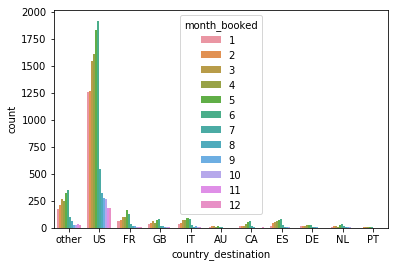

In [114]:
monthdf = userdf[userdf['date_first_booking'].notnull()]

monthdf['month_booked'] = monthdf['date_first_booking'].dt.month.astype(int)

sns.countplot(data=monthdf, x='country_destination', hue='month_booked')

# Seems like the bookings are unevenly distributed throughout the year.
# This could be a due to seasonality, but it also could be that our dataset
# itself is incomplete/skewed.

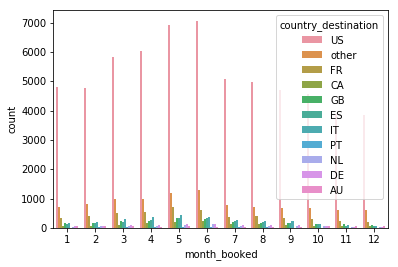

In [111]:
sns.countplot(data=monthdf, x='month_booked', hue='country_destination')

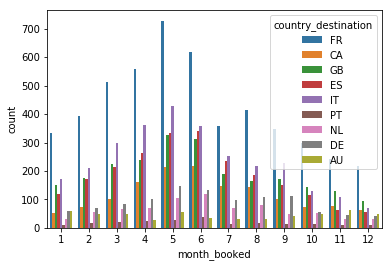

In [112]:
monthdf2 = monthdf[monthdf['country_destination'] != 'US']
monthdf2 = monthdf2[monthdf2['country_destination'] != 'other']

sns.countplot(data=monthdf2, x='month_booked', hue='country_destination')

# With no countries obviously bucking the trend, it seems this
# exploration hasn't given us any insights.
# Let's try it on the raw data...

In [115]:
rawuserdf['timestamp_first_active'] = pd.to_datetime(rawuserdf['timestamp_first_active'], format='%Y%m%d%H%M%S')
rawuserdf['date_first_booking'] = pd.to_datetime(rawuserdf['date_first_booking'])
rawuserdf['days_thinking'] = rawuserdf['date_first_booking'] - rawuserdf['timestamp_first_active']

C:\Users\d\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


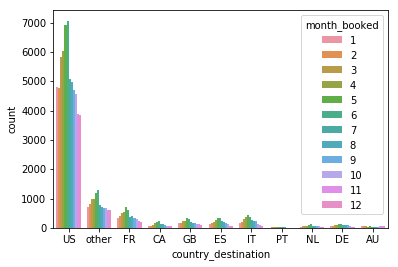

In [116]:
rawmonthdf = rawuserdf[rawuserdf['date_first_booking'].notnull()]

rawmonthdf['month_booked'] = rawmonthdf['date_first_booking'].dt.month.astype(int)

sns.countplot(data=rawmonthdf, x='country_destination', hue='month_booked')

# It looks like this 'seasonal effect' (again, could be a fluke in the data)
# is actually far more pronounced when we remove incomplete values. This would
# suggest that the incomplete/NaN values are actually correlated to time of year.

In [ ]:
# At this point, I need to change my interim data before doing any more exploration.
# It's clear the assumptions I made when deleting data were wrong.